# Server-side for creating the base_model.
In this jupyter notebook, we simulate how the server creates the base model.

#### Import Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import confusion_matrix
import tenseal as ts
import pickle

## Creating server dataset. 
The server dataset consists of all digits from 0 to 9 from the MNIST dataset. The dataset is split into 3 main parts: Server data, User A data and User B data.  
In this section, the server dataset contains the first 20,000 MNIST images and correspoding labels.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [3]:
# Slicing the MNIST original dataset to retain only part of the dataset.
x_train = x_train[:20000,:,:]
y_train = y_train[:20000]
x_test = x_test[:4000,:,:]
y_test  = y_test[:4000]

In [4]:
# Length of the new dataset
print("x_train:",len(x_train))
print("y_train:",len(y_train))
print("x_test:",len(x_test))
print("y_test:",len(y_test))

x_train: 20000
y_train: 20000
x_test: 4000
y_test: 4000


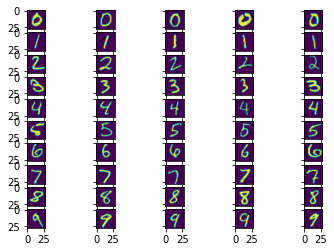

In [5]:
# Display a sample of the server dataset. 
digits = {}
for i in range(10):
    digits[i] = np.where(y_test==i)[0][:5]
#print(digits)

fig, ax = plt.subplots(10, 5, sharex='col', sharey='row')
for i in range(10):
    for j in range(5):
        ax[i, j].imshow(x_test[digits[i][j]])

## Base Model Architecture.

In [6]:
# Model's architecture.
model_base = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='relu',use_bias=False, kernel_initializer='glorot_uniform'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax',use_bias=False, kernel_initializer='glorot_uniform')
])

model_base.summary()

# model_base = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(128, activation='relu', use_bias=False, kernel_initializer='glorot_uniform'),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(10, activation='softmax', use_bias=False, kernel_initializer='glorot_uniform')
# ])

# model_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7840      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                100       
Total params: 7,940
Trainable params: 7,940
Non-trainable params: 0
_________________________________________________________________


## Compiling and training the base_model.

In [7]:
# Compiling the model.
model_base.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [8]:
# Training the base_model.
model_base.fit(x_train,
          y_train,
          batch_size=128,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/100


e:\UDM\M2_privacyinAI\code_final\venv\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


157/157 [==============================] - 1s 2ms/step - loss: 1.5435 - sparse_categorical_accuracy: 0.4825 - val_loss: 0.9241 - val_sparse_categorical_accuracy: 0.7785
Epoch 2/100
157/157 [==============================] - 0s 2ms/step - loss: 0.9028 - sparse_categorical_accuracy: 0.7012 - val_loss: 0.6649 - val_sparse_categorical_accuracy: 0.8300
Epoch 3/100
157/157 [==============================] - 0s 2ms/step - loss: 0.7654 - sparse_categorical_accuracy: 0.7455 - val_loss: 0.5734 - val_sparse_categorical_accuracy: 0.8465
Epoch 4/100
157/157 [==============================] - 0s 2ms/step - loss: 0.7017 - sparse_categorical_accuracy: 0.7693 - val_loss: 0.5271 - val_sparse_categorical_accuracy: 0.8575
Epoch 5/100
157/157 [==============================] - 0s 2ms/step - loss: 0.6703 - sparse_categorical_accuracy: 0.7736 - val_loss: 0.5045 - val_sparse_categorical_accuracy: 0.8602
Epoch 6/100
157/157 [==============================] - 0s 2ms/step - loss: 0.6385 - sparse_categorical_accu

In [9]:
# Checking which layers have weights & bias.
for layer in model_base.layers:
    print(layer.name, len(layer.weights))

flatten 0
dense 1
dropout 0
dense_1 1


In [10]:
# Saving the model.
model_base.save('saved_model/base_model')


INFO:tensorflow:Assets written to: saved_model/base_model\assets


## Predictions on the base_model

7


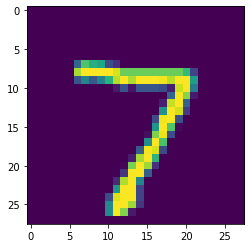

In [11]:
predictions = model_base.predict(x_test)
print(np.argmax(predictions[0]))
plt.imshow(x_test[0])
plt.show()

## Accuracy of the base_model

In [12]:
# Creating a multiclass confusion matrix before training.
confusion = confusion_matrix(y_test, np.argmax(predictions,axis=1))
confusion

array([[354,   0,   7,   2,   0,   2,   2,   0,   3,   0],
       [  0, 439,   1,   3,   0,   1,   4,   0,   2,   0],
       [  6,   4, 363,  15,   2,   0,   6,   9,  13,   0],
       [  2,   0,   8, 358,   0,  22,   0,  13,   3,   2],
       [  0,   0,   2,   2, 365,   1,  15,   2,   3,  28],
       [  8,   1,   3,  18,   4, 304,   3,   7,  16,   8],
       [  5,   3,   9,   1,  12,  11, 335,   0,   2,   0],
       [  0,  10,  10,   8,   8,   0,   1, 343,   2,  29],
       [  4,   8,   9,  11,   4,  18,   4,   6, 316,   4],
       [  3,   6,   1,  10,  21,   1,   0,   7,  11, 331]], dtype=int64)

## Creating CKKS context/keys

In [13]:
# Setup TenSEAL context.
context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=8192,
            coeff_mod_bit_sizes=[60, 40, 40, 60]
          )
          
context.generate_galois_keys()
context.global_scale = 2**40

In [14]:
# Check is context is private.
print("Is the context private?", ("Yes" if context.is_private() else "No"))

Is the context private? Yes


In [15]:
# Creating a copy of the context to share with the server. Ideally, the secret key should be drop.

public_context = context
#sk = context.secret_key()
#public_context.make_context_public()

# Context and ciphertext serialization
server_context = public_context.serialize(save_secret_key=True)

In [16]:
# Check is context is private.
print("Is the context private?", ("Yes" if context.is_private() else "No"))

Is the context private? Yes


In [17]:
key_query = {
    "context" : server_context
}

In [18]:
input_dictionary = (key_query)
file = open('key_query', 'wb')
pickle.dump(input_dictionary, file)
file.close()